# Implementation of the SPT Model 
## Develop Version

This notebook aims to test the likelihood functions and serve as unit test for any change on the model.

In [1]:
from IPython.core.display import display, HTML

Modifications: Johnny Esteves <br>
Author: Allen Pinjic - Created on June 21st, 2022

In [2]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd
import time

In [4]:
%matplotlib inline

## Fake Data

We created a set of data following the scaling relation fitted on Bocquet et al. 2019. 
$$
\left< \ln \lambda \right> = \ln A_{\lambda} + B_{\lambda} \ln{M/M_0} + C_{\lambda} E(z)/E(0)
$$

$$
\left< \ln \zeta \right> = \ln A_{sz} + B_{sz} \ln{M/M_0} + C_{sz} E(z)/E(0)
$$
<b> We added only the covariance between $\lambda$ and $\zeta$. We didn't model the error on the model parameters and on the observables. 

In [5]:
df = pd.read_csv('fake_data_Jul4.csv')
df

,z,M,lambda,chisi,zeta,lambda_true,zeta_true,res_lambda,res_zeta
0,0.141487,3.142455e+14,77.356726,5.408394,5.123547,82.169550,5.800167,-4.812824,-0.676620
1,0.178932,3.342635e+14,86.908957,7.152845,6.939971,87.986878,6.432080,-1.077921,0.507890
2,0.457212,2.608195e+14,77.888497,5.198700,4.901681,71.374014,4.715980,6.514483,0.185701
3,0.338646,3.346276e+14,105.483176,6.959804,6.740836,90.270743,6.701136,15.212433,0.039701
4,0.163748,3.421622e+14,119.360759,8.780974,8.608455,89.908974,6.643093,29.451786,1.965362
5,0.696450,3.835887e+14,105.939782,9.169123,9.004045,110.132003,9.091013,-4.192221,-0.086968
6,0.337975,3.639113e+14,114.458480,8.791683,8.619379,98.324791,7.620147,16.133688,0.999231
7,0.558427,2.987867e+14,77.604183,5.786609,5.521308,83.384751,5.968809,-5.780567,-0.447501
8,0.327534,9.125584e+14,255.599081,37.665009,37.625163,250.721727,31.137174,4.877354,6.487989
9,0.105072,3.500577e+14,72.158370,6.461490,6.225018,91.263466,6.788553,-19.105095,-0.563535


In [6]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

M0 = 3e14
Ez0 = E(0)

### Priors

In [7]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

## gaussian priors on lambda with 3 sigma from the true params
Lambda_Priors = {'A_lambda':[76.9, 3*8.2], 'B_lambda':[1.020, 3*0.080],'C_lambda':[0.23, 3*0.16],
             'scatter_lambda':[0.23, 1.5*0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

In [8]:
def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [9]:
mask = (df['lambda']>5)&(df['zeta']>3)
ix = np.where(mask)[0]
Np = ix.size

## changin here
yerr = 0.05*(df['lambda'].to_numpy())

redshift = (np.array(df['z']))[ix]
zeta = (np.array(df['zeta']))[ix]
sz_signal = (np.array(df['chisi']))[ix]
_lambda = (np.array(df['lambda']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = np.array(df['M'])[ix]

print('Number of points',Np)

Number of points 1498


In [10]:
# set up integration vectors
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
mvec = np.logspace(13.8, 15.2, 125)
lbdvec = np.linspace(0.8*np.min(np.array(df['lambda'])), 1.2*np.max(np.array(df['lambda'])), 150)
zetavec = np.linspace(1.5, 1.2*np.max(np.array(df['zeta'])), 75)

print('Vector size')
print(lbdvec.size)
print(zetavec.size)

Vector size
150
75


### MCMC Setup

In [11]:
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
Nburnin = 1000 # number of burn-in samples
Nsamples = 5000 # number of final posterior samples
walkers = 32
ndims = len(theta_true)

guess = (np.array(theta_true)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

## Implementing Very Simple Model Likelihood

Using the Simple Model Likelihood in order to see how accurate the predicted MCMC values are from the known true values. 

In this model:
* ($M_{500}$, z) are given as indepedent variables
* the errors on $\lambda$ and $\zeta$ are not considered

This approximation doens't have an integral to compute which makes the computing time much faster.

In [12]:
def log_likelihood_very_simple(theta):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
        
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass, redshift)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, redshift)
        
    # logNormal Likelihood
    lp_lbd_zeta = compute_log_pLbdZeta(_lambda, zeta,
                                       scatter_lambda, scatter_sze, rho,
                                       ln_lbd_pred, ln_zeta_pred)
        
    return np.nansum(lp_lbd_zeta)

def compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
                         ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = scatter_sze#logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = scatter_lambda#logNormal_variance(ln_lbd_pred, scatter_lambda)
    
    s_lambda_inv = np.where(s_lambda<=eps, np.inf, 1/s_lambda)
    s_zeta_inv = np.where(s_zeta<=eps, np.inf, 1/s_zeta)
    
    # avoid error messages
    rho2 = (1-rho**2)
    rho_inv = np.where(rho2<=eps, np.inf, 1/rho2)
    
    cov2 = (s_lambda)**(2)*(s_zeta)**(2)*rho2
    additional_cov = (-0.5)*np.log(np.pi*cov2)
        
    lbd_std = (np.log(Lambda) - ln_lbd_pred)*s_lambda_inv
    zeta_std = (np.log(Zeta) - ln_zeta_pred)*s_zeta_inv
    #np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2.

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    
    # total likelihood
    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    return lp_total_m

## Checking LogLikelihood Function

I know the true values used to generate the fake data. So I'll check if the true parameters are the ones that minimize the logLikelihood function.

In [13]:
log_likelihood_very_simple(theta_true)

3773.4459638029084

In [14]:
# a quick of 10% from the truth
initial = theta_true + 0.2 * np.random.randn(9)
log_likelihood_very_simple(initial)

-2627.0896051876207

In [15]:
## plotting this results
np.random.seed(42)
lps = [-1.*log_likelihood_very_simple(theta_true)]
dist = [0.]
# increase the quick from the truth
for i in [1.,5.,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*log_likelihood_very_simple(initial))
    dist.append(nDist)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in add
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


In [16]:
lps

[-3773.4459638029084,
 -3762.8665917280778,
 -2588.5836177859223,
 -3518.47588669096,
 -0.8695796694135609,
 -1873.812633895929,
 inf,
 1048.015239389811,
 -0.0]

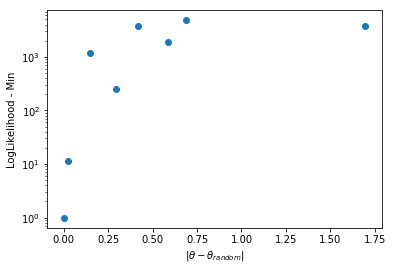

In [17]:
plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
plt.ylabel('LogLikelihood - Min')
plt.xlabel(r'|$\theta-\theta_{random}$|')
plt.yscale('log')

In [18]:
import time
start = time.time()
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_very_simple(*args)
initial = theta_true + 0.05 * np.random.randn(9)
soln = minimize(nll, initial)
end = time.time()
vsp_time = end - start
print("Very Simple Model took {0:.1f} seconds".format(vsp_time))

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in add


Very Simple Model took 0.5 seconds


In [19]:
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

Maximum likelihood estimates:
Albd = 76.337
Blbd = 1.027
Clbd = 0.309
Scatter_lbd = 0.168
rho: 0.790


In [20]:
theta_true[4:]

[76.9, 1.02, 0.29, 0.16, 0.8]

In [21]:
def logposterior_vsp(theta):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_very_simple(theta)

In [22]:
import time
from multiprocessing import Pool

pool = Pool(processes=64)              # start 64 worker processes
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior_vsp, pool=pool)
start = time.time()
sampler.run_mcmc(guess, Nsamples+Nburnin)
end = time.time()
vsp_mcmc_time = end - start
print("Very Simple Model took {0:.1f} seconds".format(vsp_mcmc_time))

Very Simple Model took 80.1 seconds


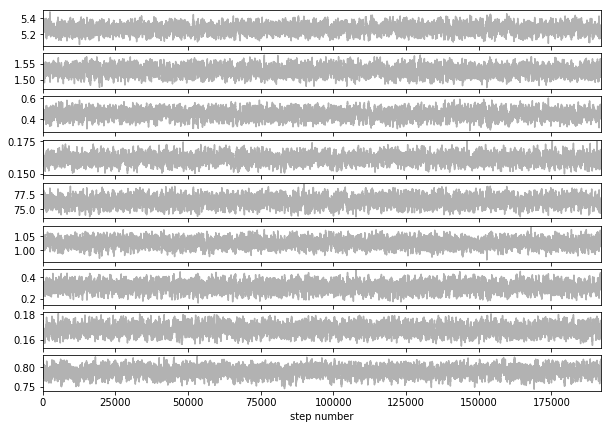

In [23]:
flat_samples = sampler.flatchain
fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
samples = flat_samples
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

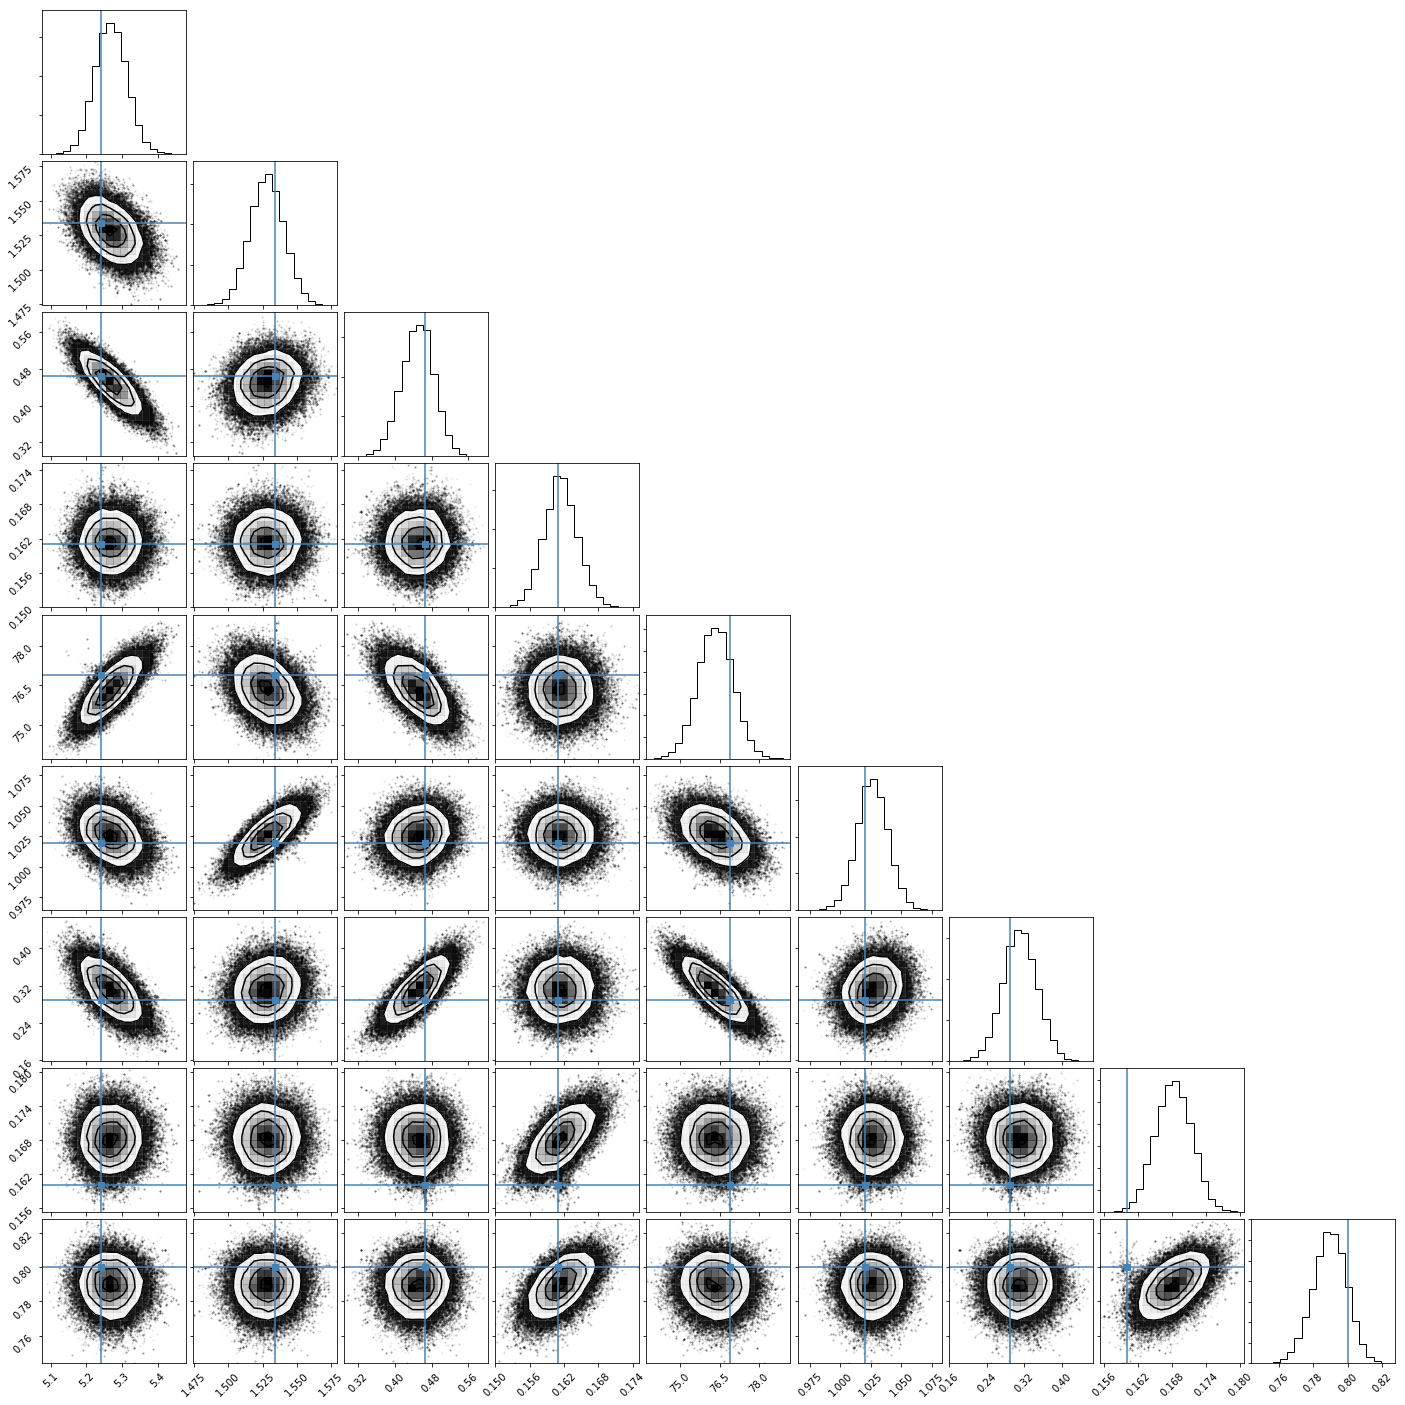

In [24]:
import corner

fig = corner.corner(flat_samples, truths=theta_true);

Most of the parameters quite well. The slope is a bit shallower due to the cuts applied on $\xi$.

## Implementing Simple LogLikelihood Model

Now we consider the errors on the observables. Doing so, we add the integration over $\lambda$ and $\zeta$.

After the previous step, for each cluster we compute:

$$
P(\lambda|\xi^{i},M^{i},z^{i}) = \int d\zeta \; P(\xi|\zeta) \times P(\zeta,\lambda|M,z)
$$
and 
$$
P(\lambda|\xi^{i},M^{i},z^{i}) = \int d\lambda \; P(\hat{\lambda}|\lambda) \times P(\lambda|\xi^{i},M^{i},z^{i})
$$
where the $P(\zeta,\lambda|M,z)$ is the multivariate gaussian distribution with a correlation factor $\rho$.

In [33]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec
# grid of lambda and zeta values to be intregated over
zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_simple(theta, indices, eps=1e-9):
    # for each cluster compute the log_likelihood
    
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_likelihood_simple(theta, ix))
    
    # missing a normalization factor
    p = np.array(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

def _likelihood_simple(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling the indepedent variables
    # there are defined as global variables
    mass_i = mass[ix]
    redshift_i = redshift[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    
    # take the indices with non zero values for P_chisi, P_lbd_hat
    # this approx. makes the code to run faster by a factor 10
    llo, lup = list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass_i, redshift_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass_i, redshift_i)
    
    # the logNormal Distribution
    lp_lbd_zeta = compute_log_pLbdZeta(ll[clo:cup,llo:lup], zz[clo:cup,llo:lup],
                                      scatter_lambda, scatter_sze, rho,
                                      ln_lbd_pred, ln_zeta_pred)
    p_lbd_zeta = np.exp(lp_lbd_zeta)
    
    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    
    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p

In [63]:
def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_chisi(zeta, xi):
    res = np.exp(-(xi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res

def prob_lbd_hat(x, mean , std):
    res = gaussian(x, mean , std)
    return res

def prob_mass(zeta, mass, z, params):
    params = A_sze, B_sze, C_sze, scatter_sze
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, z)
    ln_prob = -0.5*((np.log(zeta)-ln_zeta_pred)/scatter_sze)**2
    return ln_prob
    
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,1)
    return ilo, iup

In [ ]:
prob_mass_vec = np.array([prob_mass(sz_signal_i, mvec, z_i, theta[:4]) for sz_signal_i,z_i in zip(sz_signal,redshift)])

In [35]:
alpha = 0.075

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
print("This is prob_lbd_hat_vec shape :", prob_lbd_hat_vec.shape)

prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])


lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
print("This is lbd_indices_vec:", lbd_indices_vec[:3])

zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
print(zeta_indices_vec.shape)
print("This is zeta_indices_vec shape:", zeta_indices_vec.shape)

This is prob_lbd_hat_vec shape : (1498, 150)
This is lbd_indices_vec: [[ 9 12]
 [11 15]
 [ 9 13]]
(1498, 2)
This is zeta_indices_vec shape: (1498, 2)


In [36]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_simple(theta, indices, eps=1e-9)

In [37]:
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
indices = np.arange(len(mass))
logposterior(theta_true, indices)

1130.9096085760775

In [38]:
# a quick of 10% from the truth
initial = theta_true + 0.1 * np.random.randn(9)
logposterior(initial,indices)

760.2760116009036

In [39]:
## plotting this results
t0 = time.time()
np.random.seed(42)
lps = [-1.*logposterior(theta_true,indices)]
dist = [0.]
# increase the quick from the truth
for i in [1.,2.5,5.,7.5,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*logposterior(initial,indices))
    dist.append(nDist)

print('Total time: %.2f s'%(time.time()-t0))

Total time: 5.26 s


In [40]:
lps

[-1130.9096085760775,
 -1168.1147748338635,
 -993.3666863569605,
 -1058.8680597934315,
 -410.7507355991619,
 -879.1013686705157,
 5891.312819302635,
 353.6938036086345,
 inf,
 inf,
 inf]

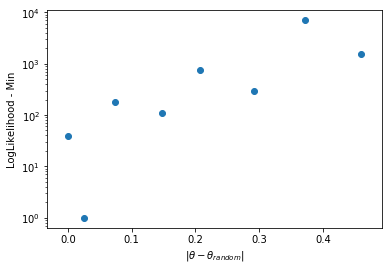

In [41]:
plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
plt.ylabel('LogLikelihood - Min')
plt.xlabel(r'|$\theta-\theta_{random}$|')
plt.yscale('log')

In [34]:
import time
from scipy.optimize import minimize

start = time.time()
np.random.seed(42)
nll = lambda *args: -logposterior(*args)
initial = theta_true + 0.05 * np.random.randn(9)
soln = minimize(nll, initial, args=indices)
end = time.time()
sp_time = end - start
print("Simple Model took {0:.1f} seconds".format(sp_time))
# print("It is {} slower than the very simple model".format(sp_time/vsp_time))

Simple Model took 514.8 seconds


In [35]:
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

Maximum likelihood estimates:
Albd = 74.304
Blbd = 1.045
Clbd = 0.316
Scatter_lbd = 0.168
rho: 0.794


The model without the integration over the mass works well. The recoverd params are very close the true values. 

In [67]:
############ Not Running MCMC ##############
############ It takes too long##############

In [64]:
# import time
# from multiprocessing import Pool

# pool = Pool(processes=64)              # start 64 worker processes
# sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[np.arange(len(mass))], pool=pool)
# start = time.time()
# sampler.run_mcmc(guess, Nsamples+Nburnin)
# end = time.time()
# sp_mcmc_time = end - start
# print("Very Simple Model took {0:.1f} seconds".format(sp_mcmc_time))
# print("It is {} slower than the very simple model".format(sp_mcmc_time/vsp_mcmc_time))

In [65]:
# flat_samples = sampler.flatchain
# fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
# samples = flat_samples
# for i in range(ndims):
#     ax = axes[i]
#     ax.plot(samples[:, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     #ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [66]:
# import corner

# fig = corner.corner(flat_samples, truths=theta_true);

## SPT Model - Marginalized over the Mass

Now we assume that the halo mass is not known. So, we will integrate the likelihood over all the possible masses weighted by the halo mass function. 

$$
\frac{d^2N}{d\zeta d\lambda}(\lambda|\xi^{i},M^{i},z^{i}) = \int dM \; P(\zeta,\lambda|M,z) \times \frac{dN}{dM}
$$

where the $P(\zeta,\lambda|M,z)$ is the multivariate gaussian distribution with a correlation factor $\rho$.

The next step to implement is to normalize the log-likelihood by the integral $\int_{40}^{\infty} d\hat{\lambda}\; P(\hat{\lambda}|\xi^i, z^i) = 1$

In [25]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

In [26]:
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [50]:
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

def log_likelihood(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_likelihood(theta, ix))
    p = np.array(probs)#/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

def _likelihood(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # forgot the mass
    redshift_i = redshift[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    llo, lup = list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, redshift_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, redshift_i)
    halo_mass_func = halo_mass_function2(redshift_i)
    
    ln_lbd_pred = ln_lbd_pred[:,np.newaxis,np.newaxis]
    ln_zeta_pred= ln_zeta_pred[:,np.newaxis,np.newaxis]
    hmf = halo_mass_func[:,np.newaxis,np.newaxis]
    
    # the logNormal Distribution
    lp_lbd_zeta = compute_log_pLbdZeta(ll[:,clo:cup,llo:lup], zz[:,clo:cup,llo:lup],
                                      scatter_lambda, scatter_sze, rho,
                                      ln_lbd_pred, ln_zeta_pred)
    p_lbd_zeta = np.exp(lp_lbd_zeta)
    
    # integrate over M
    p_lbd_zeta = np.trapz(p_lbd_zeta*hmf, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    
    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p

In [51]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood(theta, indices, eps=1e-9)

In [52]:
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
indices = np.arange(len(mass))
log_likelihood(theta_true, indices)

43515.55856046984

In [53]:
# a quick of 10% from the truth
initial = theta_true + 0.1 * np.random.randn(9)
log_likelihood(initial,indices)

42861.98354277463

In [54]:
## plotting this results
t0 = time.time()
np.random.seed(42)
lps = [-1.*logposterior(theta_true,indices)]
dist = [0.]
# increase the quick from the truth
for i in [1.,2.5,5.,7.5,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*logposterior(initial,indices))
    dist.append(nDist)

print('Total time: %.2f s'%(time.time()-t0))

Total time: 9.82 s


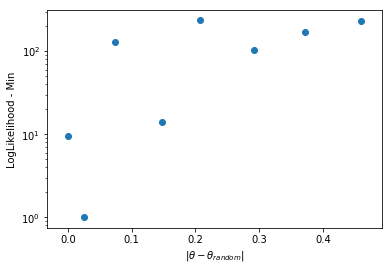

In [58]:
plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
plt.ylabel('LogLikelihood - Min')
plt.xlabel(r'|$\theta-\theta_{random}$|')
plt.yscale('log')

In [60]:
import time
from scipy.optimize import minimize

start = time.time()
np.random.seed(42)
nll = lambda *args: -logposterior(*args)
initial = theta_true + 0.05 * np.random.randn(9)
soln = minimize(nll, initial, args=indices)
end = time.time()
spt_time = end - start
print("SPT Model took {0:.1f} seconds".format(spt_time))
print("It is {} slower than the very simple model".format(spt_time/vsp_time))

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


SPT Model took 1133.7 seconds
It is 2231.20105593 slower than the very simple model


In [61]:
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

Maximum likelihood estimates:
Albd = 126.003
Blbd = 0.547
Clbd = 0.392
Scatter_lbd = 0.144
rho: 0.776


It doesn't converge to the right answer when the mass is not given as an input variable. The things that I added was the halo mass function and the integration over the mass. It seems that the normalization should matter in this case because the integration add an additional scale on the likelihood. 

In [67]:
############ Not Running MCMC ##############
############ It takes too long##############

In [68]:
# import time
# from multiprocessing import Pool

# pool = Pool(processes=64)              # start 64 worker processes
# sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[np.arange(len(mass))], pool=pool)
# start = time.time()
# sampler.run_mcmc(guess, Nsamples+Nburnin)
# end = time.time()
# spt_mcmc_time = end - start
# print("Very Simple Model took {0:.1f} seconds".format(spt_mcmc_time))
# print("It is {} slower than the very simple model".format(spt_mcmc_time/vsp_mcmc_time))

In [69]:
# flat_samples = sampler.flatchain
# fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
# samples = flat_samples
# for i in range(ndims):
#     ax = axes[i]
#     ax.plot(samples[:, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     #ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [70]:
# import corner

# fig = corner.corner(flat_samples, truths=theta_true);